# Laguna Lake Salinity prediciton using a neural net
Laguna Lake is one of the largest freshwater lakes in southeast asia and is posed to become a source of drinking water for the groing population of Manila, The Philippines. Salinity intrusion is a threat to the quality of drinking water in this region, and numerical models have been applied to estimate the magnitude and timing of the intrusion events. However, this intrusion relies on accurate bathymetric/topographic information in the Pasig River, the water way that connects the lake to the ocean. As this information is uncertain, a machine learning based approach for predicting salinity intrusion is tested and compared to the numerical model solution.

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import pylab
import keras
import matplotlib.pyplot as plt
import os
import inspect
import glob
import datetime
%matplotlib inline
sns.set()

In [28]:
model2fieldloc = {
'Pagsanjan':'PagsanjanStn18_2012-2016',
'Sanctuary':'SanctuaryStn17_2012-2016',
'West Bay' : 'WestBay_Stn1_1999-2016',
'East Bay' : 'EastBayStn2_1999-2016',
'Central B' :'CentralBayStn4_1999-2016',
'West Bay Pasi' : 'WestBayStn5_1999-2016',
'South Bay': 'SouthBayStn8_1999-2016',
'San Pedro' : 'SanPedroStn15_2012-2016',
'Sta. Rosa': 'SanRosaStn16_2012-2016'}

model2fieldsub = {'OXY' : 'DO2M',
                  'NH4' : 'NH3',
                  'NO3' : 'NO3',
                  'PO4' : 'PO4',
                  'Cl'  : 'CL',
                  'SS'  : 'TSS',
                  'BOD' : 'BOD',
                  'COD' : 'COD',
                  'TP'  : 'TP',
                  'TN'  : 'TN',
                  'ALKA': 'ALK'}


In [29]:
def MakeTS(var):
    return pd.Timestamp(var) 

def numRemove(varagin):
    newStr = ''
    for ii in varagin:
        if isnum(ii) or ii == "(" or ii == ")" or ii == "-":
            pass
        else:
            newStr = newStr + ii
    return newStr.strip()

def isnum(varagin):
    try:                    
        float(varagin)
        return True
    except ValueError:
        return False

# Settings

In [30]:
# number of retrospective periods for ANN data
backlog = 7
# length of retrospective periods (days)
interval = 7

# timestep for RNN (days)
ts = 90
station = 'WestBay_Stn1_'
meteo = False

# Feature engineering
For this application we will process a number of features. Only some of these will be used in the final model
* Salinity (the target)
* Water level of the sea, representing the daily average height. This in some way normalizes for tides, and extracts a seasonal fluctuation
* Water level of the lake

Although we would like to include rainfall, the time series is not long enough. Additionally, river inflow is only from 2004-2016, and reduces the amount of data we have. We will run the model with and without river data.


**Water quality (salinity)**

In [31]:
excelFile = '../data/water_quality/Water_Quality_data_LLDA_v2_1999_2016.xlsx'

datFile = pd.ExcelFile(excelFile)
sheets = datFile.sheet_names
dft = pd.DataFrame()

# collect all locations
for sheet in sheets:
    if 'Figures' not in sheet and 'PrimProd' not in sheet:
        dff = pd.read_excel(excelFile, sheetname = sheet)
        dff = dff[['Salinity (Chloride)','Date']]
        dff.rename(columns = {'Salinity (Chloride)' : 'Salinity ' + sheet}, inplace = True)
        dff.rename(columns = {'Date' : 'date'}, inplace = True)
        dff.set_index('date',inplace = True)
        dff.replace('-',np.nan, inplace = True)
        dff = dff[~dff.index.duplicated(keep='first')]
        dft = pd.concat([dff,dft], axis = 1, ignore_index = False)

dff = dft.copy()

In [32]:
dff

,Salinity PagsanjanStn18_2012-2016,Salinity SanctuaryStn17_2012-2016,Salinity SanRosaStn16_2012-2016,Salinity SanPedroStn15_2012-2016,Salinity SouthBayStn8_1999-2016,Salinity EastBayStn2_1999-2016,Salinity CentralBayStn4_1999-2016,Salinity WestBay_Stn1_1999-2016,Salinity WestBayStn5_1999-2016
date,,,,,,,,,
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-12,NaN,NaN,NaN,NaN,376.0,357.0,673.0,584.0,610.0
1999-02-09,NaN,NaN,NaN,NaN,461.0,372.0,640.0,558.0,536.0
1999-03-09,NaN,NaN,NaN,NaN,491.0,353.0,573.0,536.0,510.0
1999-04-06,NaN,NaN,NaN,NaN,305.0,327.0,571.0,536.0,513.0
1999-05-11,NaN,NaN,NaN,NaN,439.0,205.0,532.0,469.0,454.0
1999-06-22,NaN,NaN,NaN,NaN,439.0,365.0,476.0,443.0,424.0
1999-07-13,NaN,NaN,NaN,NaN,428.0,394.0,439.0,476.0,383.0
1999-08-10,NaN,NaN,NaN,NaN,357.0,175.0,342.0,212.0,368.0


In [33]:
dff.to_csv('../data/LagunaLake_salinity.csv')

**Meteo**

In [34]:
###########################################################################
if meteo: # will limit the time series if we include it
    meteo = '../data/hydrology/Meteo and Streamflow Data/Luzon Meteo Data - PAGASA.xlsx'
    meteoFile = pd.ExcelFile(meteo)

    locs = ['NAIA (MIA)','AMBULONG']
    dfm  = pd.DataFrame()

    for ll in locs:
        metDat = pd.read_excel(meteo, sheetname = ll)
        metDat['date'] = pd.Series()
        for ii,yy in enumerate(metDat['YEAR']):
            metDat['date'] = pd.to_datetime(metDat[['YEAR','MONTH','DAY']])
        metDat.set_index('date',inplace = True)
        metDat[metDat['RAINFALL'] == -2] = np.nan
        metDat[metDat['RAINFALL'] == 'T'] = np.nan
        dfm = pd.concat([dfm,metDat['RAINFALL']], axis = 1)
        dfm.rename(columns={'RAINFALL' : (('Rainfall %s [mm]') % ll)}, inplace = True)
        dff = pd.concat([dff,dfm[(('Rainfall %s [mm]') % ll)]], axis = 1)

In [35]:
dff

,Salinity PagsanjanStn18_2012-2016,Salinity SanctuaryStn17_2012-2016,Salinity SanRosaStn16_2012-2016,Salinity SanPedroStn15_2012-2016,Salinity SouthBayStn8_1999-2016,Salinity EastBayStn2_1999-2016,Salinity CentralBayStn4_1999-2016,Salinity WestBay_Stn1_1999-2016,Salinity WestBayStn5_1999-2016
date,,,,,,,,,
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-01-12,NaN,NaN,NaN,NaN,376.0,357.0,673.0,584.0,610.0
1999-02-09,NaN,NaN,NaN,NaN,461.0,372.0,640.0,558.0,536.0
1999-03-09,NaN,NaN,NaN,NaN,491.0,353.0,573.0,536.0,510.0
1999-04-06,NaN,NaN,NaN,NaN,305.0,327.0,571.0,536.0,513.0
1999-05-11,NaN,NaN,NaN,NaN,439.0,205.0,532.0,469.0,454.0
1999-06-22,NaN,NaN,NaN,NaN,439.0,365.0,476.0,443.0,424.0
1999-07-13,NaN,NaN,NaN,NaN,428.0,394.0,439.0,476.0,383.0
1999-08-10,NaN,NaN,NaN,NaN,357.0,175.0,342.0,212.0,368.0


**Hydological**

In [36]:
###########################################################################

excelFile = '../data/hydrology/Lake Level binary.csv'
dfw = pd.read_csv(excelFile)
dfw['date'] = dfw['date'].apply(MakeTS)
dfw.set_index('date', inplace = True)
dfw['water level (lake) [m]'] = dfw['Water Level'] - 10.47
dfw.replace('-',np.nan, inplace = True)

csvfile = '../data/waterlevel/manila_south_harbor_predic.csv'
dfo = pd.read_csv(csvfile)  
dfo['water level (ocean) [m]'] = dfo['water level [m]']
dfo['time'] = dfo['time'].apply(MakeTS)
dfo.rename(columns = {'time' : 'date'}, inplace = True)
dfo.set_index('date', inplace = True)

df = pd.concat([dfo,dfw], axis = 1)

df = pd.concat([df,dff], axis = 1, ignore_index = False)

###########################################################################
for file in glob.glob(r'../data\hydrology\Meteo and Streamflow Data\*.csv'):
    dff = pd.read_csv(file)
    dff['date'] = dff['date'].apply(MakeTS)
    dff.set_index('date', inplace = True)  
    df = pd.concat([df,dff], axis = 1, ignore_index = False)

Text(0.5,1,'target variable and main forcing')

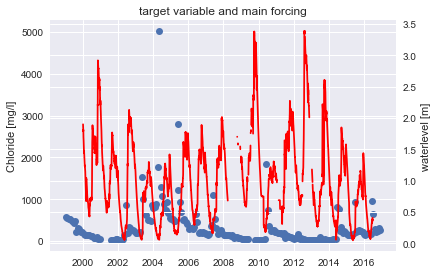

In [37]:
fig = plt.figure(1)
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])        
ax1.plot(df['Salinity ' + station + '1999-2016'], 'o')
ax2 = ax1.twinx()
ax2.plot(df['water level (lake) [m]'], 'r')
ax1.set_ylabel('Chloride [mg/l]')
ax2.set_ylabel('waterlevel [m]')
plt.title('target variable and main forcing (water level)')

In [38]:
df.columns

Index(['water level [m]', 'water level (ocean) [m]', 'Water Level',
       'water level (lake) [m]', 'Salinity PagsanjanStn18_2012-2016',
       'Salinity SanctuaryStn17_2012-2016', 'Salinity SanRosaStn16_2012-2016',
       'Salinity SanPedroStn15_2012-2016', 'Salinity SouthBayStn8_1999-2016',
       'Salinity EastBayStn2_1999-2016', 'Salinity CentralBayStn4_1999-2016',
       'Salinity WestBay_Stn1_1999-2016', 'Salinity WestBayStn5_1999-2016',
       'Angono', 'Baras', 'Binan', 'Calauan', 'Caliraya', 'Jala jala',
       'Los Banos', 'Mangahan', 'Marikina', 'Morong', 'Muntinlupa', 'Palilla',
       'Pangil', 'Pasanjan', 'Pila', 'San Cristobal', 'San Juan', 'San Pedro',
       'Siniloan', 'Sta. Cruz', 'Sta. Maria', 'Sta. Rosa', 'Taguig', 'Tanay'],
      dtype='object')

**Create time delays for the ANN**

In [42]:
###########################################################################
# create time delays
df.rename(columns = {'water level (ocean) [m]' : 'ocean'}, inplace = True)
df.rename(columns = {'water level (lake) [m]' : 'lake'}, inplace = True)
df = df[df.index.isnull() == False]
lake = {}
for ii in range(1,backlog + 1):
    lake['lake ' + str(ii)] = []
for ind,dw in enumerate(df['lake']):
    for ii in range(1, backlog + 1):
        # create each staggered array if index is larger than the distance back you will search
        if ind > (interval*ii)-2 and ind < len(df['lake'])- (interval*ii) - 1:
            lake['lake '+ str(ii)].append([df['lake'].iloc[ind-interval*ii],df['lake'].index[ind]])
        else:
            lake['lake '+ str(ii)].append([np.nan,df['lake'].index[ind]])

for ii in range(1,backlog + 1):
    tmp = pd.DataFrame(np.array(lake['lake ' + str(ii)]))
    tmp.set_index(1,inplace = True)
    tmp.rename(columns = {0 : 'lake ' + str(ii)}, inplace = True)
    df = pd.concat([df,tmp],  axis = 1)

In [43]:
df.index.rename('date', inplace = True)
df.index

DatetimeIndex(['1999-01-12', '1999-02-09', '1999-03-09', '1999-04-06',
               '1999-05-11', '1999-06-22', '1999-07-13', '1999-08-10',
               '1999-09-13', '1999-10-12',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name='date', length=6222, freq=None)

**Interpolate salinity signal so that daily values are available to match frequency of water level data**

In [44]:
###########################################################################        
# interpolate salinity data
# looped because interval between measurements is not constant
# how many values to insert? 
# div = 3

ldat = df[df['Salinity ' + station + '1999-2016'].isnull() == False].index
# indicies of valid measurements
tind = [ind for ind,ll in enumerate(df.index) if ll in ldat]
for col in df.columns:
    df[col].replace('*', np.nan,inplace = True)

for ind, time in enumerate(ldat):
    # for each safe location
    if ind > 0:
        # if not the first location
        for col in df.columns: # interpolate for all columns
            v2 = df[col].iloc[tind[ind]]
            v1 = df[col].iloc[tind[ind-1]]
            # choose the indicies that break the interval into the desired steps
            # inter = int(np.floor((tind[ind] - tind[ind-1])/(div+1)))
            inter = 1
            if inter != 0:
                x = np.arange(tind[ind-1],tind[ind],inter)
                arr = np.interp(x,[tind[ind-1],tind[ind]],[v1,v2])
                df[col].iloc[x] = arr 

In [45]:
df.to_csv('../data/LagunaLake_clean.csv')

In [46]:
df.index

DatetimeIndex(['1999-01-12', '1999-02-09', '1999-03-09', '1999-04-06',
               '1999-05-11', '1999-06-22', '1999-07-13', '1999-08-10',
               '1999-09-13', '1999-10-12',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name='date', length=6222, freq=None)

# Load and filter as needed
* in this step the desired features are chosen

In [64]:
file = '../data/LagunaLake_clean.csv'
df = pd.read_csv(file)
df['date'] = df['date'].apply(MakeTS)
df.set_index('date',inplace = True)
max_dict = {}
for cind, col in enumerate(df.columns):
    if 'water' in col or station in col or 'lake' in col or 'ocean' in col or cind >=14:
        # normalize
        # df[col] = (df[col] - df[col].mean()) / df[col].std()
        max_dict[col] = df[col].max()
        df[col] = df[col] / df[col].max()
        print('adding ' + col)
    else:
        df.drop(col, axis = 1, inplace = True)

df.dropna(axis = 0, inplace = True)

adding water level [m]
adding ocean
adding lake
adding Salinity WestBay_Stn1_1999-2016
adding Baras
adding Binan
adding Calauan
adding Caliraya
adding Jala jala
adding Los Banos
adding Mangahan
adding Marikina
adding Morong
adding Muntinlupa
adding Palilla
adding Pangil
adding Pasanjan
adding Pila
adding San Cristobal
adding San Juan
adding San Pedro
adding Siniloan
adding Sta. Cruz
adding Sta. Maria
adding Sta. Rosa
adding Taguig
adding Tanay
adding lake 1
adding lake 2
adding lake 3
adding lake 4
adding lake 5
adding lake 6
adding lake 7


In [65]:
df.describe()

,water level [m],ocean,lake,Salinity WestBay_Stn1_1999-2016,Baras,Binan,Calauan,Caliraya,Jala jala,Los Banos,...,Sta. Rosa,Taguig,Tanay,lake 1,lake 2,lake 3,lake 4,lake 5,lake 6,lake 7
count,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,...,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000,3349.000000
mean,-0.023709,-0.023709,0.295788,0.079470,0.020018,0.012448,0.024552,0.049795,0.022706,0.014087,...,0.013155,0.011582,0.023063,0.295248,0.279518,0.282097,0.301509,0.295283,0.276289,0.281736
std,0.538651,0.538651,0.184762,0.107424,0.045988,0.030759,0.053411,0.095941,0.043960,0.032594,...,0.031553,0.027585,0.049679,0.186119,0.180762,0.185427,0.191221,0.187203,0.176397,0.182050
min,-0.851708,-0.851708,0.019175,0.003644,0.000636,0.000440,0.001344,0.003728,0.001394,0.000880,...,0.000448,0.000274,0.001212,0.015773,0.026946,0.020710,0.028617,0.015538,0.017804,0.020710
25%,-0.547847,-0.547847,0.139479,0.025556,0.001288,0.000848,0.002579,0.007473,0.002648,0.001724,...,0.000860,0.000492,0.002529,0.142609,0.132057,0.129667,0.143973,0.140868,0.135333,0.135038
50%,-0.069360,-0.069360,0.270511,0.043068,0.002054,0.001337,0.006872,0.019067,0.004579,0.002659,...,0.001329,0.000767,0.004153,0.270617,0.259581,0.259194,0.273980,0.271686,0.258259,0.260774
75%,0.479090,0.479090,0.422712,0.101533,0.017083,0.007746,0.022605,0.052590,0.021844,0.008768,...,0.010264,0.008346,0.020393,0.414162,0.390505,0.402156,0.426187,0.410616,0.379668,0.390533
max,0.938748,0.938748,0.961969,1.000000,0.440522,0.278413,0.513465,1.000000,0.418975,0.323881,...,0.318236,0.216672,0.495384,0.992114,0.988024,1.000000,1.000000,1.000000,1.000000,1.000000


# ANN
We use the "backlog" number of time period of length "interval" to predict the salinity using an ANN

In [66]:
target = df.pop([ii for ii in df. columns if station in ii][0])

var= [ii for ii in df.columns if 'lake' in ii]
var.append('ocean')
df = df[var]
df.columns

Index(['lake', 'lake 1', 'lake 2', 'lake 3', 'lake 4', 'lake 5', 'lake 6',
       'lake 7', 'ocean'],
      dtype='object')

In [67]:
model = keras.Sequential()
model.add(keras.layers.Dense(2 * len(df.columns), input_dim = len(df.columns), activation = 'tanh'))
model.add(keras.layers.Dense(2 * len(df.columns), activation = 'relu'))
model.add(keras.layers.Dense(1, activation = 'relu'))

model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['accuracy'])

history = model.fit(df, target,  epochs=200, batch_size=50)

Epoch 1/200
3349/3349 [==============================] - 0s 83us/step - loss: 0.0204 - acc: 0.0000e+00
Epoch 2/200
3349/3349 [==============================] - 0s 19us/step - loss: 0.0118 - acc: 0.0000e+00
Epoch 3/200
3349/3349 [==============================] - 0s 19us/step - loss: 0.0085 - acc: 0.0000e+00
Epoch 4/200
3349/3349 [==============================] - 0s 21us/step - loss: 0.0075 - acc: 0.0000e+00
Epoch 5/200
3349/3349 [==============================] - 0s 19us/step - loss: 0.0069 - acc: 0.0000e+00
Epoch 6/200
3349/3349 [==============================] - 0s 19us/step - loss: 0.0065 - acc: 0.0000e+00
Epoch 7/200
3349/3349 [==============================] - 0s 19us/step - loss: 0.0062 - acc: 0.0000e+00
Epoch 8/200
3349/3349 [==============================] - 0s 19us/step - loss: 0.0059 - acc: 0.0000e+00
Epoch 9/200
3349/3349 [==============================] - 0s 18us/step - loss: 0.0058 - acc: 0.0000e+00
Epoch 10/200
3349/3349 [==============================] - 0s 19us/step - 

3349/3349 [==============================] - 0s 17us/step - loss: 0.0011 - acc: 2.9860e-04
Epoch 158/200
3349/3349 [==============================] - 0s 17us/step - loss: 0.0012 - acc: 2.9860e-04
Epoch 159/200
3349/3349 [==============================] - 0s 19us/step - loss: 0.0012 - acc: 2.9860e-04
Epoch 160/200
3349/3349 [==============================] - 0s 23us/step - loss: 0.0012 - acc: 2.9860e-04
Epoch 161/200
3349/3349 [==============================] - 0s 22us/step - loss: 0.0011 - acc: 2.9860e-04
Epoch 162/200
3349/3349 [==============================] - 0s 21us/step - loss: 0.0011 - acc: 2.9860e-04
Epoch 163/200
3349/3349 [==============================] - 0s 19us/step - loss: 0.0012 - acc: 2.9860e-04
Epoch 164/200
3349/3349 [==============================] - 0s 17us/step - loss: 0.0011 - acc: 2.9860e-04
Epoch 165/200
3349/3349 [==============================] - 0s 16us/step - loss: 0.0011 - acc: 2.9860e-04
Epoch 166/200
3349/3349 [==============================] - 0s 20us/st

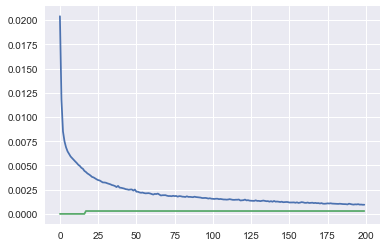

In [68]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])

Text(0.5,1,'WestBay_Stn1_')

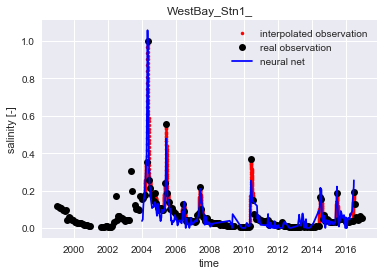

In [69]:
plt.plot(target.index, target, 'r.', label = 'interpolated observation')

dat = pd.read_csv('../data/LagunaLake_salinity.csv')
dat['date'] = dat['date'].apply(MakeTS)
dat.set_index('date', inplace = True)

plt.plot(dat.index, dat['Salinity WestBay_Stn1_1999-2016'] / max_dict[target.name],'ko', label = 'real observation')

plt.plot(df.index, model.predict(df), 'b-', label = 'neural net')
plt.legend()

plt.xlabel('time')
plt.ylabel('salinity [-]')
plt.title(station)

# RNN

In [70]:
file = '../data/LagunaLake_clean.csv'
df = pd.read_csv(file)
df['date'] = df['date'].apply(MakeTS)
df.set_index('date',inplace = True)
max_dict = {}
for cind, col in enumerate(df.columns):
    if 'water' in col or station in col or 'lake' in col or 'ocean' in col or cind >=14:
        if 'lake ' not in col: 
            # normalize
            # df[col] = (df[col] - df[col].mean()) / df[col].std()
            max_dict[col] = df[col].max()
            df[col] = df[col] / df[col].max()
            print('adding ' + col)
    else:
        df.drop(col, axis = 1, inplace = True)

df.dropna(axis = 0, inplace = True)

adding water level [m]
adding ocean
adding lake
adding Salinity WestBay_Stn1_1999-2016
adding Baras
adding Binan
adding Calauan
adding Caliraya
adding Jala jala
adding Los Banos
adding Mangahan
adding Marikina
adding Morong
adding Muntinlupa
adding Palilla
adding Pangil
adding Pasanjan
adding Pila
adding San Cristobal
adding San Juan
adding San Pedro
adding Siniloan
adding Sta. Cruz
adding Sta. Maria
adding Sta. Rosa
adding Taguig
adding Tanay


In [71]:
# X must be of dim (samples, time steps, features)
# rainfall series is not long enough to include
target = df.pop([ii for ii in df. columns if station in ii][0])

X = np.array(df)
X = np.reshape(X, (1, X.shape[0], X.shape[1]))
# memory size
X_l = np.zeros((X.shape[1] , ts, len(df.columns))) * np.nan
Y_l = np.zeros((X.shape[1])) * np.nan
# create timesteps array
for time in range(0, X_l.shape[0]):
    if time < ts-1:
        pass
    else:

        X_l[time,:,:] = X[0, (time+1-ts):time+1, :]

        # time at 60 will be the 61st number, and will not line up. Thus we take the 60th number at index 59
        Y_l[time] = target[time]
        
# clip the skipped part
X_l = X_l[ts-1:,:,:]
Y_l = Y_l[ts-1:]
pred_time = df.index[ts-1:]

In [72]:
X_l.shape

(3260, 90, 33)

In [73]:
model = keras.Sequential()
model.add(keras.layers.LSTM(100, input_shape = (X_l.shape[1], X_l.shape[2])))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['accuracy'])
history = model.fit(X_l, Y_l , epochs=70)        

W0815 11:00:38.135793 11268 deprecation.py:506] From D:\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0815 11:00:38.319823 11268 deprecation.py:323] From D:\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/70
3260/3260 [==============================] - 4s 1ms/step - loss: 0.0200 - acc: 0.0000e+00
Epoch 2/70
3260/3260 [==============================] - 3s 974us/step - loss: 0.0087 - acc: 0.0000e+00
Epoch 3/70
3260/3260 [==============================] - 3s 989us/step - loss: 0.0042 - acc: 3.0675e-04
Epoch 4/70
3260/3260 [==============================] - 3s 1ms/step - loss: 0.0031 - acc: 3.0675e-04
Epoch 5/70
3260/3260 [==============================] - 3s 1ms/step - loss: 0.0029 - acc: 3.0675e-04
Epoch 6/70
3260/3260 [==============================] - 3s 1ms/step - loss: 0.0025 - acc: 3.0675e-04
Epoch 7/70
3260/3260 [==============================] - 3s 1ms/step - loss: 0.0024 - acc: 3.0675e-04
Epoch 8/70
3260/3260 [==============================] - 3s 1ms/step - loss: 0.0020 - acc: 3.0675e-04
Epoch 9/70
3260/3260 [==============================] - 3s 1ms/step - loss: 0.0019 - acc: 3.0675e-04
Epoch 10/70
3260/3260 [==============================] - 3s 1ms/step - loss: 0.0019 - a

# Visualize 

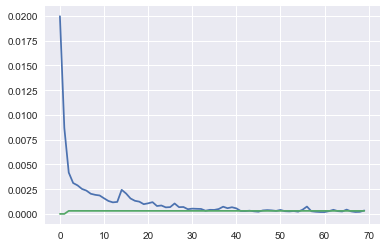

In [75]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])

Text(0.5,1,'WestBay_Stn1_')

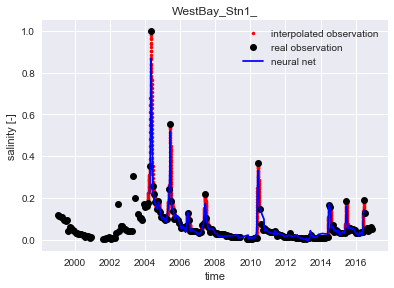

In [76]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])               
ax1.plot(target, 'r.', label = 'interpolated observation')

dff = pd.read_csv('../data/LagunaLake_salinity.csv')
dff['date'] = dff['date'].apply(MakeTS)
dff.set_index('date', inplace = True)
plt.plot(dff.index, dff['Salinity WestBay_Stn1_1999-2016'] / max_dict[target.name],'ko', label = 'real observation')

ax1.plot(pred_time, model.predict(X_l), 'b-', label = 'neural net')
ax1.legend()

ax1.set_xlabel('time')
ax1.set_ylabel('salinity [-]')
plt.title(station)


**Remove the rivers, so the time series can be 4 years longer. These earlier years will be used as test data.**

In [77]:
df = pd.read_csv(file)
df['date'] = df['date'].apply(MakeTS)
df.set_index('date',inplace = True)
max_dict = {}
for cind, col in enumerate(df.columns):
    if 'water' in col or station in col or 'lake' in col or 'ocean' in col :
        # normalize
        # df[col] = (df[col] - df[col].mean()) / df[col].std()
        max_dict[col] = df[col].max()
        df[col] = df[col] / df[col].max()
    else:
        df.drop(col, axis = 1, inplace = True)

df.dropna(axis = 0, inplace = True)

In [78]:
target = df.pop([ii for ii in df. columns if station in ii][0])

X = np.array(df)
X = np.reshape(X, (1, X.shape[0], X.shape[1]))
# memory size = instances x times per instance x features
X_l = np.zeros((X.shape[1] , ts, len(df.columns))) * np.nan
Y_l = np.zeros((X.shape[1])) * np.nan

# create timesteps array
for time in range(0, X_l.shape[0]):
    if time < ts-1:
        # not enough space to look back at
        pass
    else:
        X_l[time,:,:] = X[0, (time+1-ts):time+1, :]
        # time at 60 will be the 61st number, and will not line up. Thus we take the 60th number at index 59
        Y_l[time] = target[time]
        
# clip the skipped part
X_l = X_l[ts-1:,:,:]
Y_l = Y_l[ts-1:]
pred_time = df.index[ts-1:]

**Train-Test split**

In [79]:
print(len(target))
print(len(Y_l))
target = target.iloc[ts-1:]
ind = np.argmin(abs((target.index - pd.Timestamp('2004-01-01'))))
target.index[ind]
target.index[ind]
X_train = X_l[ind:,:,:]
Y_train = Y_l[ind:]
X_test  = X_l[:ind,:,:]
Y_test  = Y_l[:ind]

4741
4652


**LSTM model**

In [80]:
model = keras.Sequential()
model.add(keras.layers.LSTM(100, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1))

model.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['accuracy'])
history = model.fit(X_train, Y_train , epochs=80)    

Epoch 1/80
3353/3353 [==============================] - 4s 1ms/step - loss: 0.0102 - acc: 0.0000e+00
Epoch 2/80
3353/3353 [==============================] - 3s 1ms/step - loss: 0.0080 - acc: 0.0000e+00
Epoch 3/80
3353/3353 [==============================] - 3s 1ms/step - loss: 0.0062 - acc: 0.0000e+00
Epoch 4/80
3353/3353 [==============================] - 3s 1ms/step - loss: 0.0050 - acc: 2.9824e-04
Epoch 5/80
3353/3353 [==============================] - 3s 1ms/step - loss: 0.0040 - acc: 2.9824e-04
Epoch 6/80
3353/3353 [==============================] - 3s 1ms/step - loss: 0.0035 - acc: 2.9824e-04
Epoch 7/80
3353/3353 [==============================] - 4s 1ms/step - loss: 0.0030 - acc: 2.9824e-04
Epoch 8/80
3353/3353 [==============================] - 4s 1ms/step - loss: 0.0029 - acc: 2.9824e-04
Epoch 9/80
3353/3353 [==============================] - 4s 1ms/step - loss: 0.0029 - acc: 2.9824e-04
Epoch 10/80
3353/3353 [==============================] - 4s 1ms/step - loss: 0.0028 - acc: 

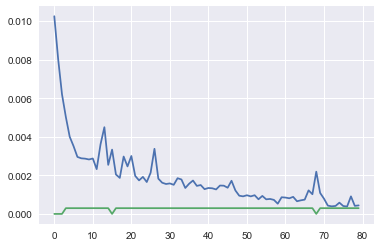

In [81]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['acc'])

**Evaluate performance on training set**

Text(0.5,1,'WestBay_Stn1_')

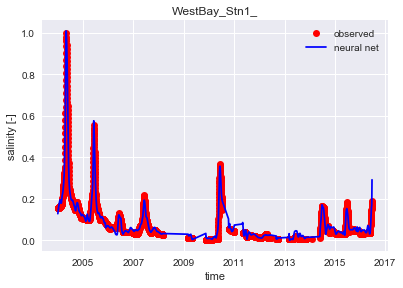

In [82]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])               
ax1.plot(pred_time[ind:], Y_train, 'ro', label = 'observed')
ax1.plot(pred_time[ind:], model.predict(X_train), 'b-', label = 'neural net')
ax1.legend()
#ax1.set_xlim(pd.Timestamp('2013-01-01'), pd.Timestamp('2014-01-01')) 

ax1.set_xlabel('time')
ax1.set_ylabel('salinity [-]')
plt.title(station)


**Evaluate using test set**

Text(0.5,1,'WestBay_Stn1_')

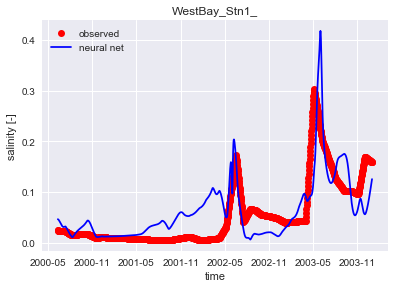

In [83]:
fig = plt.figure()
ax1 = fig.add_axes([0.1,0.1,0.8,0.8])               
ax1.plot(pred_time[:ind], Y_test, 'ro', label = 'observed')
ax1.plot(pred_time[:ind], model.predict(X_test), 'b-', label = 'neural net')
ax1.legend()
#ax1.set_xlim(pd.Timestamp('2013-01-01'), pd.Timestamp('2014-01-01')) 

ax1.set_xlabel('time')
ax1.set_ylabel('salinity [-]')
plt.title(station)

# Comparison to numerical model

West Bay-18
Salinity WestBay_Stn1_1999-2016


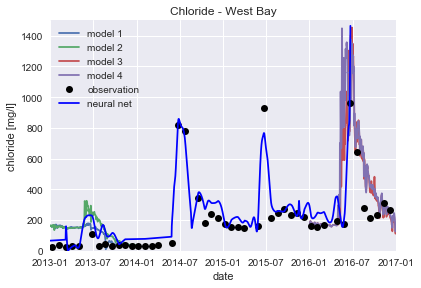

In [84]:
dff = pd.read_csv('../data/LagunaLake_salinity.csv')
dff['date'] = dff['date'].apply(MakeTS)
dff.set_index('date', inplace = True)
model11 = pd.read_csv(r'../data/numerical_model/R02/salinity_layer10.csv')
model21 = pd.read_csv(r'../data/numerical_model/G03/salinity_layer10.csv')
model12 = pd.read_csv(r'../data/numerical_model/R08/salinity_layer10.csv')
model22 = pd.read_csv(r'../data/numerical_model/R09/salinity_layer10.csv')
for loc in model11.columns:
    if numRemove(loc) in model2fieldloc.keys():
        if station in model2fieldloc[numRemove(loc)]:
            print(loc)
            dat = dff.copy()
            modTime = []
            for ii,jj in enumerate(model11['Date']):
                # ordinal is not the same convention as in matlab?
                dyy = datetime.datetime.fromordinal(int(np.floor(model11['Date'][ii]))) - datetime.timedelta(days = 365)
                dyfr = model11['Date'][ii] % int(np.floor(model11['Date'][ii]))
                modTime.append(dyy + datetime.timedelta(days = dyfr))
            dat.replace('*', np.nan, inplace = True)
            dat.dropna(inplace = True, axis = 0)
            fig = plt.figure()
            ax = fig.add_axes([0.1,0.1,0.8,0.8])
            # salinity to chloride conversion
            ax.plot(modTime,model11[loc] * 1000 /  1.64846, label = 'model 1')
            ax.plot(modTime,model21[loc] * 1000 /  1.64846, label = 'model 2')
            
            modTime = []
            for ii,jj in enumerate(model12['Date']):
                # ordinal is not the same convention as in matlab?
                dyy = datetime.datetime.fromordinal(int(np.floor(model12['Date'][ii]))) - datetime.timedelta(days = 365)
                dyfr = model12['Date'][ii] % int(np.floor(model12['Date'][ii]))
                modTime.append(dyy + datetime.timedelta(days = dyfr))           
            ax.plot(modTime,model12[loc] * 1000 /  1.64846, label = 'model 3')
            ax.plot(modTime,model22[loc] * 1000 /  1.64846, label = 'model 4')

            print('Salinity ' + model2fieldloc[numRemove(loc)])
            ax.plot(dat.index,dat['Salinity ' + model2fieldloc[numRemove(loc)]],'ko', label = 'observation')
                
            plt.grid

            plt.title('Chloride' + ' - ' + numRemove(loc))
            plt.xlabel('date')
            plt.ylabel('chloride [mg/l]')
            ax.set_ylim([0,1500])

ax.plot(pred_time, model.predict(X_l) * max_dict[target.name], 'b-', label = 'neural net')
ax.set_xlim(pd.Timestamp('2013-01-01'), pd.Timestamp('2017-01-01')) 
plt.legend()